# Credit Card Approval Prediction
## STA group 6
---
> Given the data for application and credit history, classify a person as **good** or **bad**. A good person will be approved a credit card. A bad person will be denied the credit card.

>**What do we want to answer** - How can the financial industry utilize machine learning to predict the probability of future defaults and credit card borrowings of clients?

> Data set - [Credit Card Approval Dataset](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction?select=application_record.csv)




# Loading required libraries and reading data
---
* pandas used for data wrangling
* bayes_opt, xgboost and scikit-learn used for modelling

In [2]:
# google colab drive mount
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install bayesian-optimization

# importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

# import xgboost as xgb
# from xgboost import XGBClassifier
# from bayes_opt import BayesianOptimization

from sklearn.tree import plot_tree, DecisionTreeClassifier

import contextlib
import warnings

In [3]:
# reading the dataset - app and credit files
app = pd.read_csv("data/application_record.csv")
credit = pd.read_csv("data/credit_record.csv")

In [4]:
print(app.shape)
app.head(3)

(438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0


> Application data has ~400K rows and 18 columns. Columns are as follows:

* **ID**	Client number	
* **CODE_GENDER**	Gender	
* **FLAG_OWN_CAR**	Is there a car	
* **FLAG_OWN_REALTY**	Is there a property	
* **CNT_CHILDREN**	Number of children	
* **AMT_INCOME_TOTAL**	Annual income	
* **NAME_INCOME_TYPE**	Income category	
* **NAME_EDUCATION_TYPE**	Education level	
* **NAME_FAMILY_STATUS**	Marital status	
* **NAME_HOUSING_TYPE**	Way of living	
* **DAYS_BIRTH**	Birthday. Count backwards from current day (0), -1 means yesterday
* **DAYS_EMPLOYED**	Start date of employment. Count backwards from current day(0). If positive, it means the person currently unemployed.

* **FLAG_MOBIL**	Is there a mobile phone	
* **FLAG_WORK_PHONE**	Is there a work phone	
* **FLAG_PHONE**	Is there a phone	
* **FLAG_EMAIL**	Is there an email	
* **OCCUPATION_TYPE**	Occupation	
* **CNT_FAM_MEMBERS**	Family size



In [5]:
print(credit.shape)
credit.head(5)

(1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


> Credit data has ~1M rows and 3 columns. Columns are as follows:

* **ID	Client number**

* **MONTHS_BALANCE**	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on

* **STATUS**	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [6]:
# Removing columns with duplicate IDS
# removed 438557 - 438510 (47 duplicates)
print(app['ID'].shape, app['ID'].unique().shape)

# Number of rows left after dropping duplicates
app = app.drop_duplicates(subset=['ID'], keep='first')
print(app.shape)

(438557,) (438510,)
(438510, 18)


# Assigning labels
---
* Credit dataset has ***STATUS*** field that shows the credit history of customers for different months
* There is a class imbalance because of a low proportion of ***bad*** customers
* We assume that if the customer has payments overdue by more than 2 months or if they have defaulted they are a ***bad*** customer, if a customer has payments overdue by a month or if they have payed on time they are a ***good*** customer

In [7]:
# needs to be done because X and C are characters
def mask_X_C(row):
    if row == 'X':
        return '-1'
    elif row == 'C':
        return '-2'
    else:
        return row

print("initial values\n", credit['STATUS'].value_counts())

credit['STATUS'] = credit['STATUS'].map(mask_X_C)
print("\nmasked for X and C\n", credit['STATUS'].value_counts())

# get max of STATUS and assign throughout
credit['MAX_STATUS'] = credit.groupby('ID')['STATUS'].transform('max')

print("\nafter assigning max values\n", credit['MAX_STATUS'].value_counts())

initial values
 C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

masked for X and C
 -2    442031
0     383120
-1    209230
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

after assigning max values
 0     769212
1     120830
-1    101523
-2     34029
2      11130
5       6839
3       3246
4       1766
Name: MAX_STATUS, dtype: int64


In [8]:
# 0 - good , 1 -bad
def assign_labels(row):
    if row == '-1':
        return 0
    elif row == '-2':
        return 0
    elif row == '0':
        return 0
    elif row == '1':
        return 1
    elif row == '2':
        return 1
    elif row == '3':
        return 1
    elif row == '4':
        return 1
    elif row == '5':
        return 1

credit['label'] = credit['MAX_STATUS'].map(assign_labels)

#  class imbalance (previous was 98:2) - now the imbalance is 87:13
print('class imbalance')
credit['label'].value_counts() / credit['label'].value_counts().sum() * 100

class imbalance


0    86.285101
1    13.714899
Name: label, dtype: float64

###  Merging application and credit datasets, checking and treating NULL values
---
* Customer information from application data is merged with credit information
* NULL values from the merged data are treated

In [9]:
# application data is unique
print(app['ID'].unique().shape, app.shape)

# credit data has a lot of duplicates
print(credit['ID'].unique().shape ,credit.shape)

# dropping duplicates from credit data (since we already use max in labels)
credit_df = credit[['ID', 'label']].drop_duplicates()

print(credit_df.shape)

(438510,) (438510, 18)
(45985,) (1048575, 5)
(45985, 2)


In [10]:
merged_app_credit = pd.merge(app, credit_df, on=['ID'])

# intesection is correct
print(merged_app_credit.shape)
print(app[app['ID'].isin(credit_df['ID'])].shape)

merged_app_credit.head(4)
# dataset has duplicates for all other columns except ids

(36457, 19)
(36457, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [11]:
# this can be tried if we dont want duplicates in terms of other columns
# # removing duplicate rows
# dedup_merged_app_credit = merged_app_credit.drop_duplicates(subset=merged_app_credit.columns.difference(['ID']))
# dedup_merged_app_credit.head(10)

In [12]:
# Dropping id column as it wil not be used in modelling

#dropping id
dataset = merged_app_credit.drop('ID', axis=1)
dataset.head(3)


# checking nulls
missing_val_checks = pd.DataFrame({'missing' : dataset.isnull().sum(), 'missing_percent' : (dataset.isnull().sum()/len(dataset))*100})
print(missing_val_checks)
# Occupation type has 31% missing value

                     missing  missing_percent
CODE_GENDER                0         0.000000
FLAG_OWN_CAR               0         0.000000
FLAG_OWN_REALTY            0         0.000000
CNT_CHILDREN               0         0.000000
AMT_INCOME_TOTAL           0         0.000000
NAME_INCOME_TYPE           0         0.000000
NAME_EDUCATION_TYPE        0         0.000000
NAME_FAMILY_STATUS         0         0.000000
NAME_HOUSING_TYPE          0         0.000000
DAYS_BIRTH                 0         0.000000
DAYS_EMPLOYED              0         0.000000
FLAG_MOBIL                 0         0.000000
FLAG_WORK_PHONE            0         0.000000
FLAG_PHONE                 0         0.000000
FLAG_EMAIL                 0         0.000000
OCCUPATION_TYPE        11323        31.058507
CNT_FAM_MEMBERS            0         0.000000
label                      0         0.000000


In [13]:
# checking the different occupation types
print(dataset['OCCUPATION_TYPE'].value_counts())

# adding 'Unknown' to the group of occupations that are NULL
dataset['OCCUPATION_TYPE'][dataset['OCCUPATION_TYPE'].isnull()] =  'Unknown'

#rechecking missing values
print(dataset.isnull().any())

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64
CODE_GENDER            False
FLAG_OWN_CAR           False
FLAG_OWN_REALTY        False
CNT_CHILDREN           False
AMT_INCOME_TOTAL       False
NAME_INCOME_TYPE       False
NAME_EDUCATION_TYPE    False
NAME_FAMILY_STATUS     False
NAME_HOUSING_TYPE      False
DAYS_BIRTH             False
DAYS_EMPLOYED          False
FLAG_MOBIL             False
FLAG_WORK_PHONE        False
FLAG_PHONE             False
FLAG_EMAIL        

/tmp/ipykernel_1935/1619299195.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['OCCUPATION_TYPE'][dataset['OCCUPATION_TYPE'].isnull()] =  'Unknown'


##  Stratified train-test split
---
* Since we have an imbalanced dataset, we use a stratified train-test split to have equal imbalance in both test and train data
* The train-test split will be 70:30

In [14]:
# Creating stratified train and test samples
y = dataset.pop('label').to_frame()
X = dataset

In [15]:
# using a 70:30 split in train:test
X_train, X_test, y_train, y_test = train_test_split(
        X, y,stratify=y, test_size=0.3)

In [16]:
# Checking the number of rows and columns
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25519, 17), (25519, 1), (10938, 17), (10938, 1))

In [17]:
# checking class imbalance in train
y_train['label'].value_counts() / len(y_train['label']) * 100 

0    88.228379
1    11.771621
Name: label, dtype: float64

In [18]:
# checking class imbalance in test
y_test['label'].value_counts() / len(y_test['label']) * 100

0    88.233681
1    11.766319
Name: label, dtype: float64

# Exploratory data analysis - Univariate and Bivariate analysis
---
* Dividing variables in catagorical and continuous
* Doing univariate analysis on all numeric variables
* Bivariate analysis on continuous variables
* Bivariate analysis on catagorical variables

In [19]:
# based on this amt_income_total, days_birth and days_employed are continuous 
# rest all are catagorical

# checking variable types
print(X_train.info())

# creating lists for types of variables
continuous_vars = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']
catagorical_vars =  X_train.describe().columns.difference(continuous_vars).tolist() + \
                    ['OCCUPATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
                    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'CODE_GENDER']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25519 entries, 17452 to 16227
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CODE_GENDER          25519 non-null  object 
 1   FLAG_OWN_CAR         25519 non-null  object 
 2   FLAG_OWN_REALTY      25519 non-null  object 
 3   CNT_CHILDREN         25519 non-null  int64  
 4   AMT_INCOME_TOTAL     25519 non-null  float64
 5   NAME_INCOME_TYPE     25519 non-null  object 
 6   NAME_EDUCATION_TYPE  25519 non-null  object 
 7   NAME_FAMILY_STATUS   25519 non-null  object 
 8   NAME_HOUSING_TYPE    25519 non-null  object 
 9   DAYS_BIRTH           25519 non-null  int64  
 10  DAYS_EMPLOYED        25519 non-null  int64  
 11  FLAG_MOBIL           25519 non-null  int64  
 12  FLAG_WORK_PHONE      25519 non-null  int64  
 13  FLAG_PHONE           25519 non-null  int64  
 14  FLAG_EMAIL           25519 non-null  int64  
 15  OCCUPATION_TYPE      25519 non-n

In [20]:
# univariate analysis for continuous variables
X_train.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,25519.000000,2.551900e+04,25519.000000,25519.000000,25519.0,25519.000000,25519.000000,25519.000000,25519.000000
mean,0.429327,1.863664e+05,-15968.281712,58620.437517,1.0,0.223912,0.294212,0.090286,2.198323
std,0.732244,1.013276e+05,4189.152810,137084.217402,0.0,0.416872,0.455697,0.286596,0.904034
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19421.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.575000e+05,-15562.000000,-1557.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12469.000000,-410.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,14.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,15.000000


##  Bivariate with continuous variables

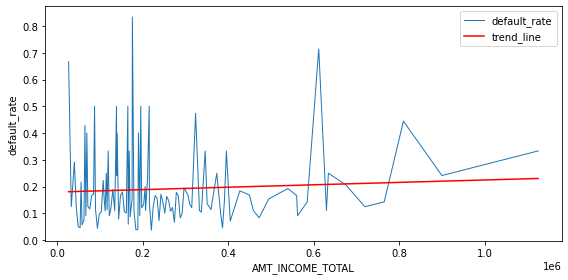

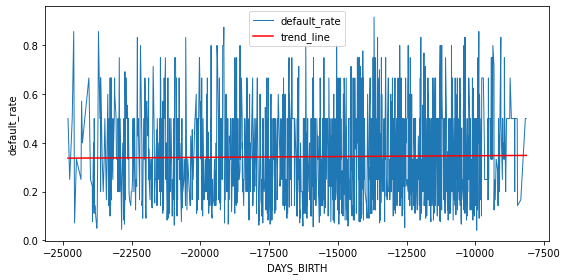

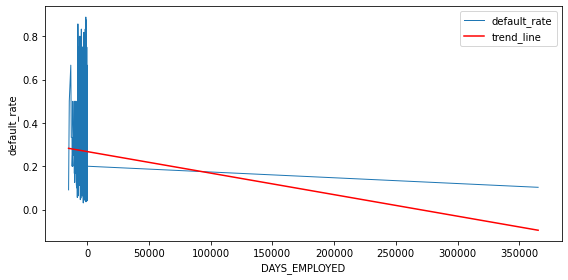

In [21]:
#calculating default rate for continuous variables
def default_rate_continous_var_calc(row):
    default_rate = float(row['CODE_GENDER'][1] / float(row['CODE_GENDER'][0] + row['CODE_GENDER'][1]))
    return default_rate


# Checking default rate for continuous variables
for col in continuous_vars:
    fig,(ax) = plt.subplots(figsize=(8,4), ncols=1)

    pivot_test = pd.pivot_table(X_train,index=(col, y_train['label']), values=('CODE_GENDER'), aggfunc=len)

    pivot_test = pivot_test.unstack()
    pivot_test = pivot_test.reset_index()

    pivot_test['default_rate'] = pivot_test.apply(default_rate_continous_var_calc, axis=1)

    x_axis = pivot_test[col][pivot_test['default_rate'].notnull()]

    
    #plotting line
    default_rate, = ax.plot(x_axis,pivot_test['default_rate'][pivot_test['default_rate'].notnull()],linewidth = 1, label = 'default_rate')

    #processing for trendline
    z = np.polyfit(x_axis, pivot_test['default_rate'][pivot_test['default_rate'].notnull()],1)
    p = np.poly1d(z)

    #plotting trendline
    trend_line, = ax.plot(pivot_test[str(col)][(pivot_test['CODE_GENDER'][1].notnull()) & 
                                                (pivot_test['CODE_GENDER'][0].notnull())],
                          p(pivot_test[str(col)][(pivot_test['CODE_GENDER'][1].notnull()) & 
                                                  (pivot_test['CODE_GENDER'][0].notnull())]),"r-", label = 'trend_line')


    plt.xlabel(str(col))
    plt.ylabel('default_rate')

    ax.legend([default_rate, trend_line], ['default_rate', 'trend_line'])
    fig.tight_layout()
    fig.show()
    
# The trends show variance for all continuous variables

###  Bivariate analysis with catagorical variables

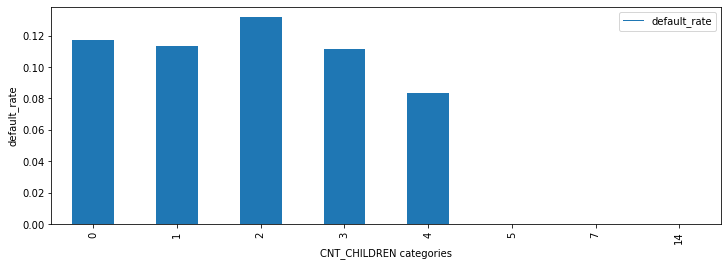

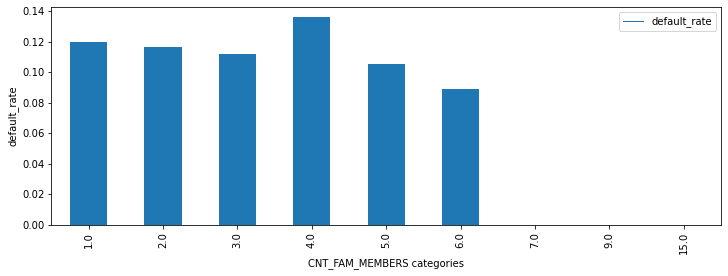

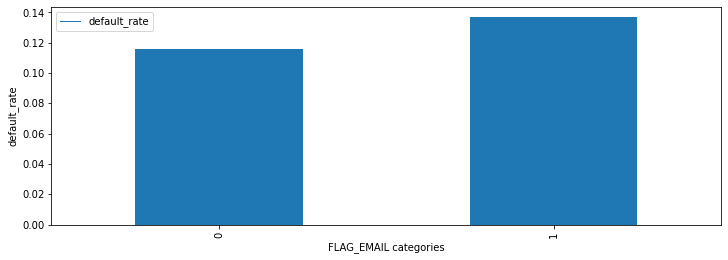

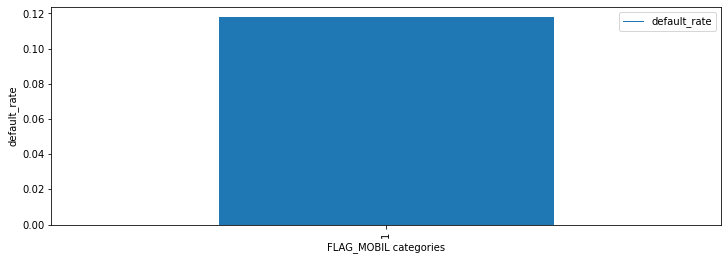

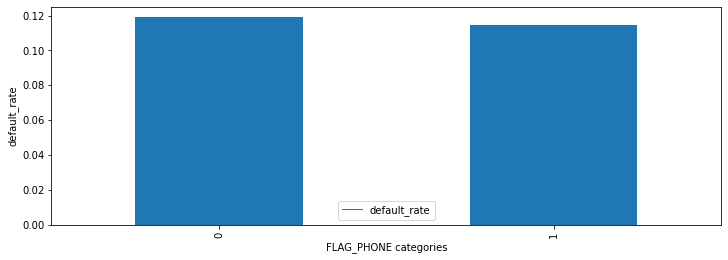

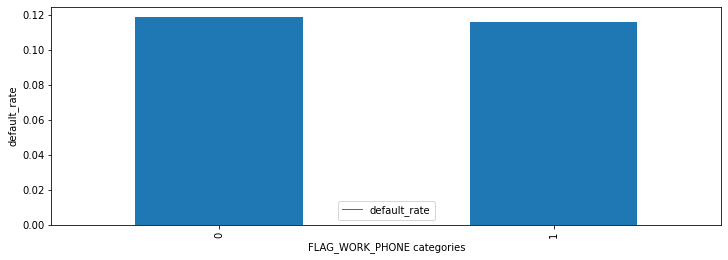

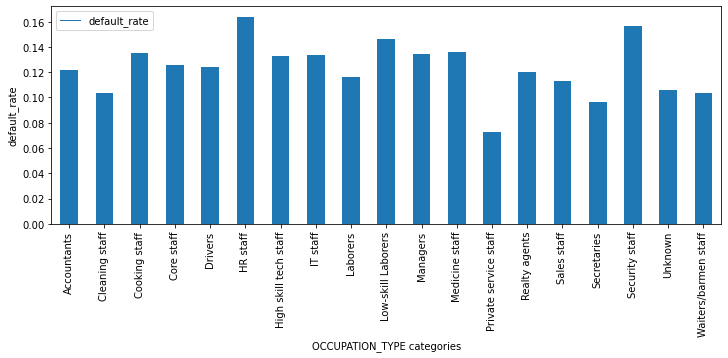

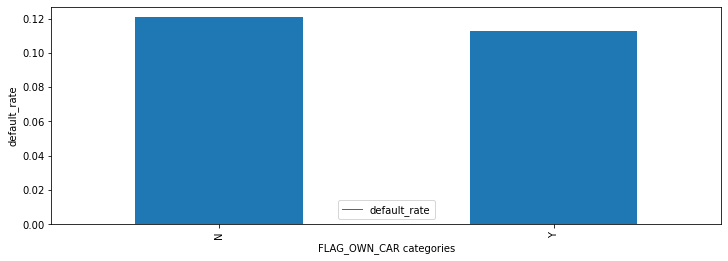

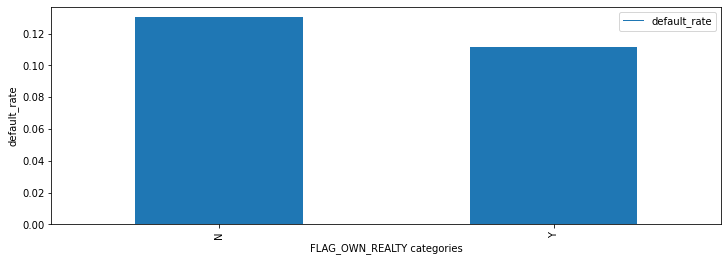

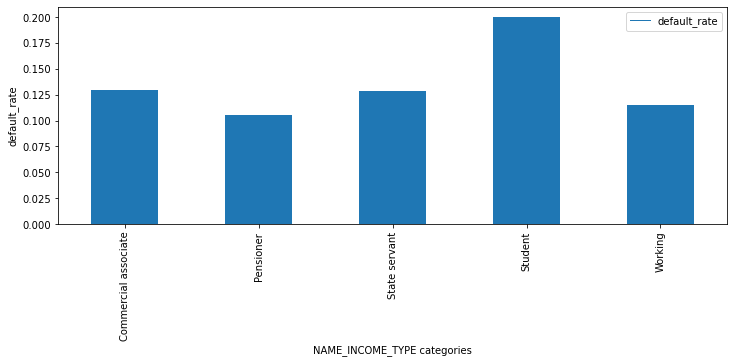

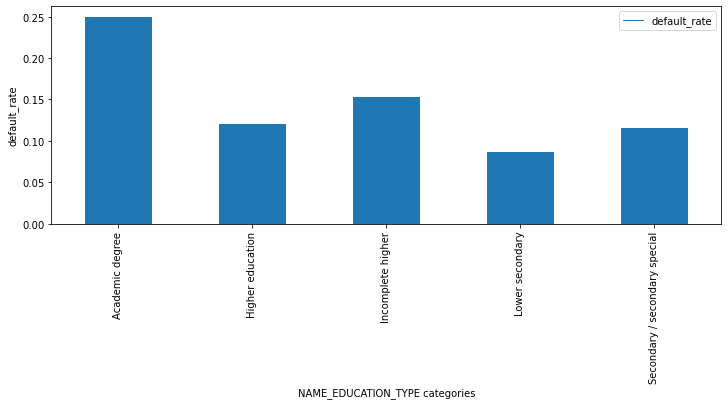

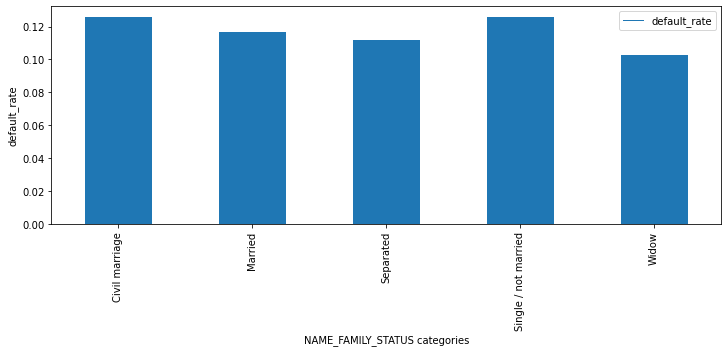

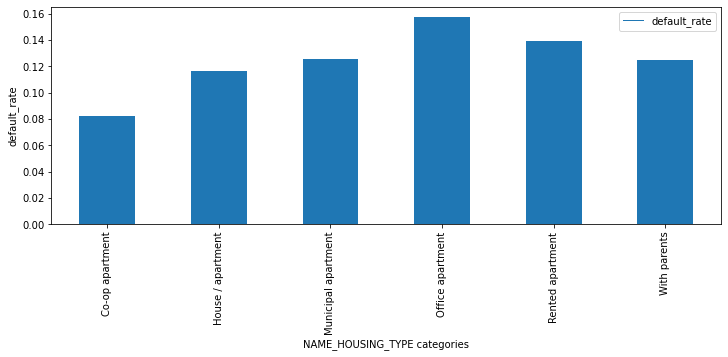

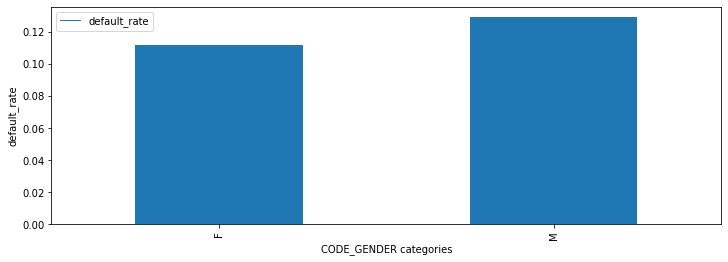

In [22]:
#this function calculates the default rate for categorical variables
def default_rate_categorical_var_calc(row):
    default_rate = float(row['AMT_INCOME_TOTAL'][1] / float(row['AMT_INCOME_TOTAL'][0] + row['AMT_INCOME_TOTAL'][1]))
    return default_rate

#here we do a bivariate for column vs default rate for catagorical variables
for col in catagorical_vars:
    fig,(ax) = plt.subplots(figsize=(12,4), ncols=1)
    
    pivot_test = pd.pivot_table(X_train,index=(str(col), y_train['label']), values=('AMT_INCOME_TOTAL'), aggfunc=len)

    pivot_test = pivot_test.unstack()
    pivot_test = pivot_test.reset_index()

    pivot_test['default_rate'] = pivot_test.apply(default_rate_categorical_var_calc, axis=1)
    pivot_test['default_rate'].plot(kind='bar')
    plt.legend([default_rate], ['default_rate'])
    plt.xlabel(str(col) + ' categories')
    plt.ylabel('default_rate')
    plt.xticks(np.array(pivot_test.index),pivot_test[str(col)])

> flag phone, flag work phone, flag own car dont show much variation for default
rate but other variables show a good variation

# Preprocessing for model building
---
* Creating dummy variables for qualitative variables
* Scaling data for model building

In [23]:
# converting the catagorical columns to dummies, get_dummies only converts the
# char or str type columns to dummies and keeps the numeric cateogories as is
# this is helpful in assigning correct weight to the rows
X_train_cat = pd.get_dummies(X_train[catagorical_vars], drop_first=True)
X_test_cat = pd.get_dummies(X_test[catagorical_vars], drop_first=True )

In [24]:
X_train_cat.head(1)

,CNT_CHILDREN,CNT_FAM_MEMBERS,FLAG_EMAIL,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,CODE_GENDER_M
17452,1,3.0,0,1,1,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1


In [25]:
 X_test_cat.head(1)

,CNT_CHILDREN,CNT_FAM_MEMBERS,FLAG_EMAIL,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,...,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,CODE_GENDER_M
7515,1,3.0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# combine dummy columns and other variables
X_train_dummied = pd.concat([X_train[continuous_vars], X_train_cat], axis=1)
X_test_dummied = pd.concat([X_test[continuous_vars], X_test_cat], axis=1)

In [27]:
# scale and trasnform data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dummied)
y_train_np = np.array(y_train)
X_test_scaled = scaler.fit_transform(X_test_dummied)
y_test_np = np.array(y_test)

In [28]:
# assigning weights to labels (for weight penaly during model building)
weight = np.ones(shape=(len(y_train_np),1))
weight[y_train_np == 0] = (sum(y_train_np) / len(y_train_np))[0]

# Model Fit - 1. Random Forest and feature importance
---
* Running Random Forest for getting the best parameters
* Fitting model with optimum parameters
* Model evaluation and results
* Selecting optimal cutoff for high recall

In [34]:
# First fitting the baseline model
clf=RandomForestClassifier()
clf.fit(X_train_scaled, y_train)

/Users/dishagandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier()

In [35]:
# predictions for the baseline model
preds = clf.predict(X_test_scaled)

In [36]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, preds))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, preds))
print('\n')

=== Confusion Matrix ===
[[9513  138]
 [1138  149]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      9651
           1       0.52      0.12      0.19      1287

    accuracy                           0.88     10938
   macro avg       0.71      0.55      0.56     10938
weighted avg       0.85      0.88      0.85     10938





In [37]:
# Doing hyperparameter tuning

# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 9)]
min_samples_split = [1, 2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}

In [38]:
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 30, cv = 5,
                               verbose=2,
                               random_state=42, n_jobs = 4)
rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/dishagandhi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [0.88737798 0.88228379 0.88349864 0.8838905  0.8840472  0.88228379
 0.88588889 0.88322432 0.88357697 0.88224461 0.88714284 0.88228379
        nan 0.88588892 0.88228379 0.88228379 0.88690779 0.88228379
        nan 0.88228379 0.88686861 0.88600646 0.88506603 0.88326352
 0.88326349        nan 0.88769142 0.88232298 0.88228379 0.88146092]
  category=UserWarning
/Users/dishagandhi/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [1, 2, 5, 10, 15,
                                                              20, 30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, verbose=2)

In [39]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 100,
 'criterion': 'entropy',
 'bootstrap': True}

In [40]:
preds = rf_random.predict(X_test_scaled)

In [41]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, preds))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, preds))
print('\n')

=== Confusion Matrix ===
[[9629   22]
 [1241   46]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9651
           1       0.68      0.04      0.07      1287

    accuracy                           0.88     10938
   macro avg       0.78      0.52      0.50     10938
weighted avg       0.86      0.88      0.84     10938





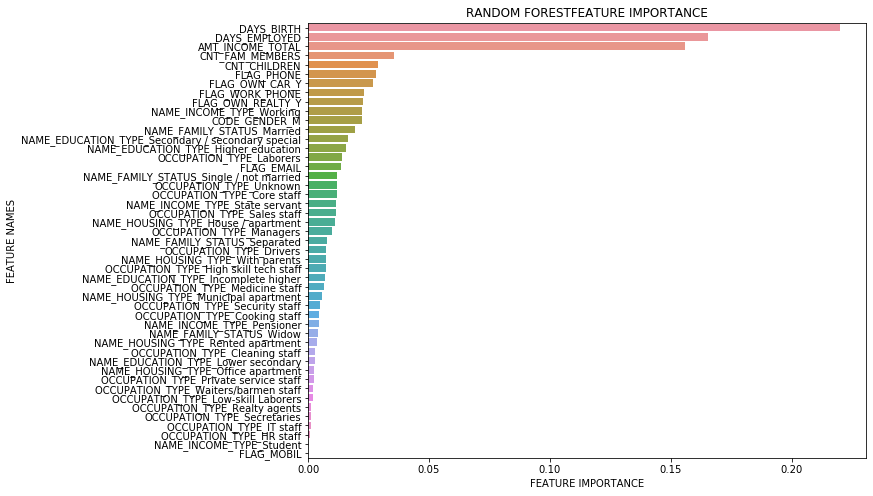

In [52]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
plot_feature_importance(rf_random.best_estimator_.feature_importances_,X_train_dummied.columns,'RANDOM FOREST')

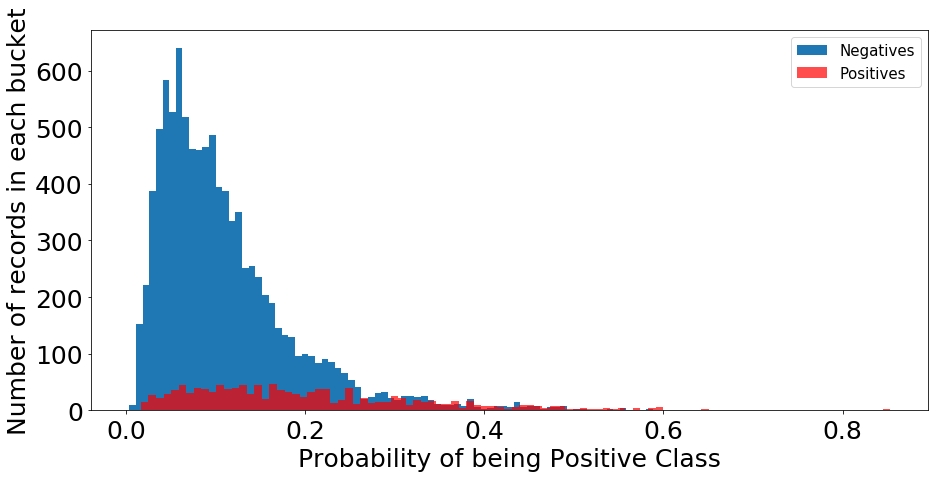

In [46]:
predicted_probs = rf_random.predict_proba(X_test_scaled)
prediction = predicted_probs[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y_test['label'] == 0], bins=100, label='Negatives')
plt.hist(prediction[y_test['label'] == 1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

# Model Fit - 2. XGB with CV and feature importance
---
* Model fit with 5-fold cross validation
* Plotting feature importance
* Evaluating the recall score
* Plotting probability distribution of predicted classes
* Plotting precision-recall curve for 2 class model

In [50]:
X_y_train = pd.concat([X_train_dummied, y_train], axis=1)

In [186]:
def modelfit(alg, dtrain, predictors, response_var='label', useTrainCV=True, cv_folds=5, early_stopping_rounds=100):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[response_var].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[response_var], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\Report")
    print ("AUC Score (Train): %f" % roc_auc_score(dtrain[response_var], dtrain_predprob))
    
    print('Feature Importance Score')
    ax = xgb.plot_importance(alg)
    ax.figure.set_size_inches(10,8)

\Report
AUC Score (Train): 0.851710
Feature Importance Score


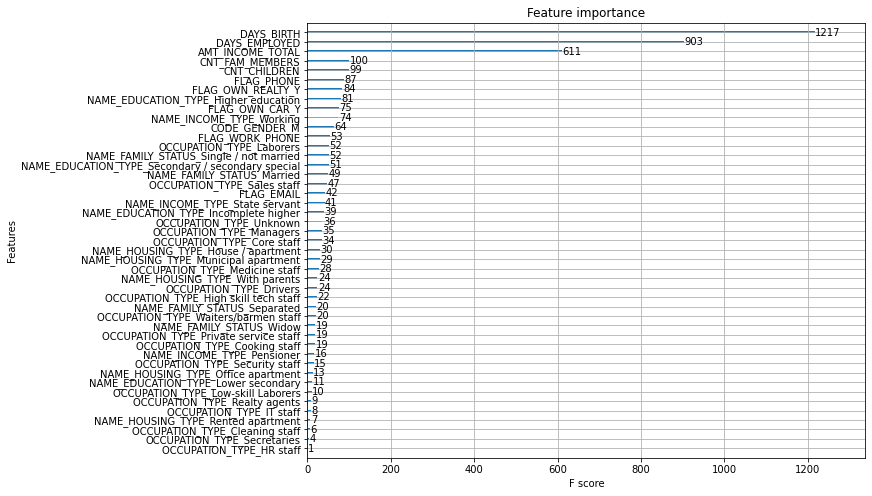

In [187]:
xgb1 = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=5, min_child_weight=1, 
                     gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                     nthread=4, scale_pos_weight=(1-sum(y_train['label'])/len(y_train)))

modelfit(xgb1, X_y_train, X_y_train.columns.tolist()[:-1], response_var='label')

In [81]:
predicted_vals = xgb1.predict(X_test_dummied)

In [82]:
recall_score(y_test, predicted_vals)

0.02097902097902098

In [83]:
confusion_matrix(y_test, predicted_vals)

array([[9632,   19],
       [1260,   27]])

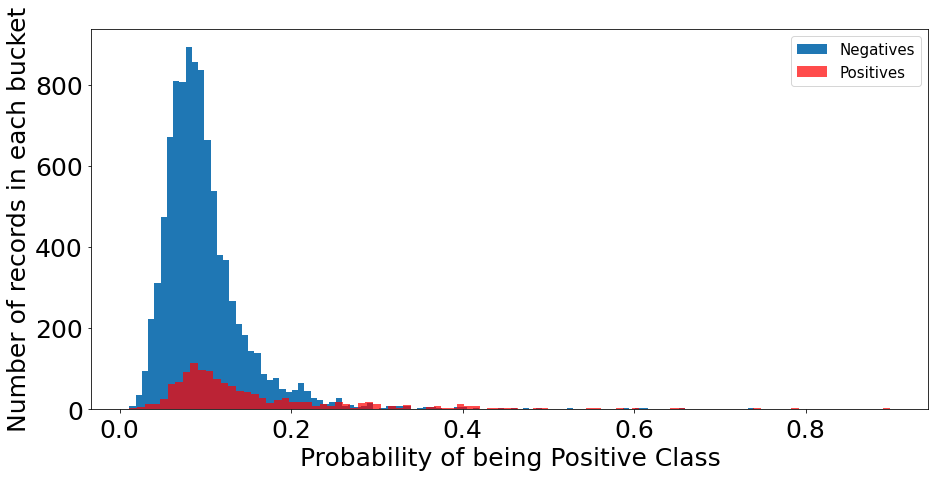

In [84]:
predicted_probs = xgb1.predict_proba(X_test_dummied)
prediction = predicted_probs[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y_test['label'] == 0], bins=100, label='Negatives')
plt.hist(prediction[y_test['label'] == 1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

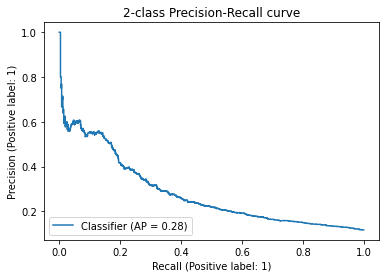

In [85]:
# y_score = classifier.decision_function(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, predicted_probs[:, 1])
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Model Fit - 3. XGB with Random Grid Search for hyperparameter tuning
---
* Model fit with Grid Search CV
* Limitations of Grid Search CV - computation power and time
* Model evaluation
* Plotting probability distribution of predicted classes

In [86]:
# Search space too large - takes more than 2 hrs for optimized search
%%time
param_test1  = {
 'max_depth': list(range(2,3,2)),
 'learning_rate': [0.1, 0.01],
 'min_child_weight': list(range(1,3,1)),
    'subsample':[0.5,1.0],
    'colsample_bytree' : [0.5,1.0],
    'n_estimators' : [300, 400]
}

kfold = StratifiedKFold(n_splits=5, shuffle=True)
gsearch1 = GridSearchCV(estimator = 
                        XGBClassifier(objective= 'binary:logistic', scale_pos_weight=(1-sum(y_train['label'])/len(y_train))), 
                        param_grid = param_test1, scoring='recall',n_jobs=-1, cv=kfold, verbose=1)

gfit = gsearch1.fit(X_y_train[X_y_train.columns.tolist()[:-1]],X_y_train['label'])

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 10.9 s, sys: 576 ms, total: 11.4 s
Wall time: 10min 16s


In [87]:
gfit.best_params_, gfit.best_score_

({'colsample_bytree': 0.5,
  'learning_rate': 0.1,
  'max_depth': 2,
  'min_child_weight': 2,
  'n_estimators': 400,
  'subsample': 0.5},
 0.0006666666666666668)

In [88]:
predicted_vals = gfit.best_estimator_.predict(X_test_dummied)

In [89]:
recall_score(y_test, predicted_vals)

0.002331002331002331

In [92]:
accuracy_score(y_test, predicted_vals)

0.8826110806363138

In [90]:
confusion_matrix(y_test, predicted_vals)

array([[9651,    0],
       [1284,    3]])

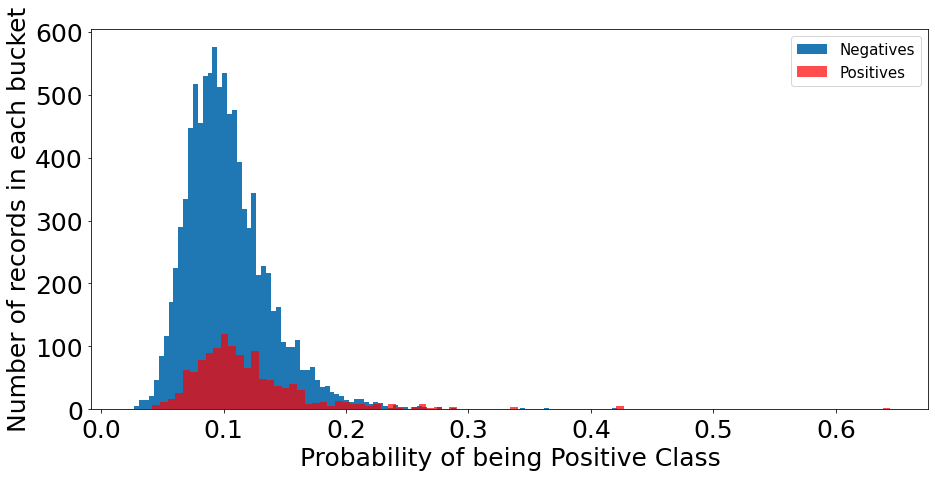

In [91]:
predicted_probs = gfit.predict_proba(X_test_dummied)
prediction = predicted_probs[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y_test['label'] == 0], bins=100, label='Negatives')
plt.hist(prediction[y_test['label'] == 1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

# Model Fit - 4. XGB with Bayesian Opt for hyperparameter tuning
---
* Running Bayesian Optimization for getting the best parameters
* Fitting model with optimum parameters
* Model evaluation and results
* Selecting optimal cutoff for high recall

In [93]:
log_file = open('xgboost_credit_card_approval.log', 'a')
AUCbest = -1.
ITERbest = 0

# XGB Cv constructor
def XGB_CV(
          learning_rate,
          max_depth,
          gamma,
          min_child_weight,
          max_delta_step,
          subsample,
          colsample_bytree
         ):

    global AUCbest
    global ITERbest


# parameter initialization
    paramt = {
              'booster' : 'gbtree',
              'max_depth' : int(max_depth),
              'gamma' : gamma,
              'objective' : 'binary:logistic',
              'silent' : True,
              'eval_metric': 'auc',
              'subsample' : max(min(subsample, 1), 0),
              'colsample_bytree' : max(min(colsample_bytree, 1), 0),
              'min_child_weight' : min_child_weight,
              'max_delta_step' : int(max_delta_step),
              'learning_rate' : learning_rate,
              'scale_pos_weight' :(1-sum(y_train['label'])/len(y_train)),
              }
# folds  
    folds = 5  
    cv_score = 0

    print("\n Search parameters (%d-fold validation):\n %s" % (folds, paramt), file=log_file )
    log_file.flush()

# adding cv
    xgbc = xgb.cv(
                    paramt,
                    dtrain,
                    stratified = True,
                    num_boost_round = 300,
                    nfold = folds,
                    # verbose_eval = 10,
                    early_stopping_rounds = 100,
                    metrics = 'auc',
                    show_stdv = True
               )

# print train and validation sores
    val_score = xgbc['test-auc-mean'].iloc[-1]
    train_score = xgbc['train-auc-mean'].iloc[-1]
    print(' Stopped after %d iterations with train-auc = %f val-auc = %f ( diff = %f ) train-gini = %f val-gini = %f' % ( len(xgbc), train_score, val_score, (train_score - val_score), (train_score*2-1),
(val_score*2-1)) )
    if ( val_score > AUCbest ):
        AUCbest = val_score
        ITERbest = len(xgbc)

    return (val_score*2) - 1

In [94]:
#initialize xgb matrix with train set
dtrain = xgb.DMatrix(X_train_scaled, label = y_train)

In [95]:
#parameter search space
XGB_BO = BayesianOptimization(XGB_CV, {
                                     'max_depth': (2, 30),
                                     'gamma': (0.001, 10.0),
                                     'learning_rate':(0.2, 0.8),
                                     'min_child_weight': (1, 10),
                                     'max_delta_step': (1, 10),
                                     'subsample': (0.1, 1.0),
                                     'colsample_bytree' :(0.1, 1.0)
                                    })

In [96]:
%%time
print('-'*130)
print('-'*130, file=log_file)
log_file.flush()

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    XGB_BO.maximize(init_points=4, n_iter=8, acq='ei', xi=0.0)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------
 Stopped after 300 iterations with train-auc = 0.831855 val-auc = 0.662881 ( diff = 0.168973 ) train-gini = 0.663709 val-gini = 0.325763
|  1        |  0.3258   |  0.1645   |  8.435    |  0.7892   |  2.852    |  29.8     |  3.406    |  0.808    |
 Stopped after 300 iterations with train-auc = 0.953170 val-auc = 0.724325 ( diff = 0.228845 ) train-gini = 0.906340 val-gini = 0.448649
|  2        |  0.4486   |  0.7606   |  3.572    |  0.4693   |  6.473    |  21.97    |  3.692    |  0.7953   |
 Stopped after 300 iterations with train-auc = 0.962345 val-auc = 0.726511 ( diff = 0.235834 ) train-gini = 0.924691 val-gini = 0.453022
|  3        |  0.4

In [97]:
# taking the values with highest val-AUC and minimum diff
xgb_opt_bayesian = XGBClassifier(learning_rate =  0.2, n_estimators=300, max_depth=23, min_child_weight=1.0, 
                     gamma=  0.001, subsample=1.0, colsample_bytree= 1.0, objective= 'binary:logistic', 
                      max_delta_step= 10, scale_pos_weight=(1-sum(y_train['label'])/len(y_train)))

In [100]:
%%time
xgb_opt_bayesian.fit(X_train_scaled, y_train['label'])

CPU times: user 55.5 s, sys: 88.7 ms, total: 55.6 s
Wall time: 55.4 s


XGBClassifier(colsample_bytree=1.0, gamma=0.001, learning_rate=0.2,
              max_delta_step=10, max_depth=23, min_child_weight=1.0,
              n_estimators=300, scale_pos_weight=0.882283788549708,
              subsample=1.0)

In [101]:
prediction_vals = xgb_opt_bayesian.predict(X_test_scaled)

In [102]:
confusion_matrix(y_test, prediction_vals)

array([[9521,  130],
       [1146,  141]])

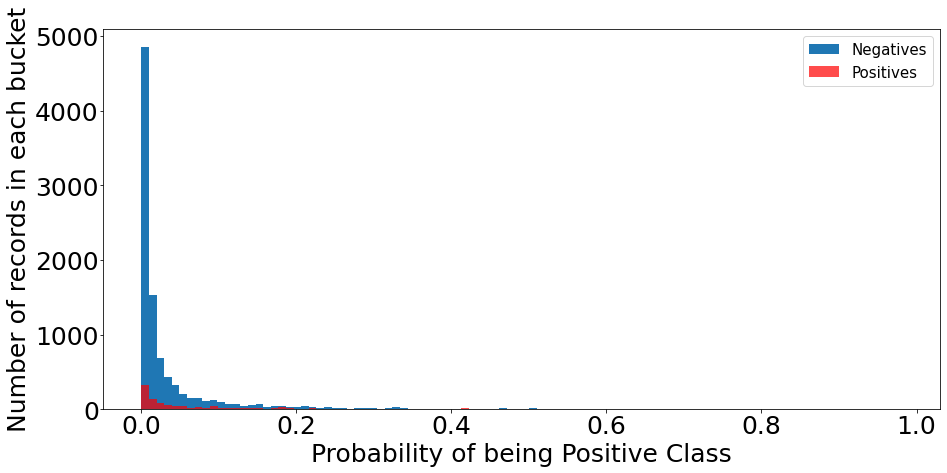

In [103]:
predicted_probs = xgb_opt_bayesian.predict_proba(X_test_scaled)
prediction = predicted_probs[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y_test['label'] == 0], bins=100, label='Negatives')
plt.hist(prediction[y_test['label'] == 1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=1)
plt.show() 

### Selecting optimal cutoff for high recall
* This helps us minimize the False Positives

In [105]:
%%time
predicted_probs_for_cutoff = xgb_opt_bayesian.predict_proba(X_test_scaled)
predicted_probs_for_cutoff

CPU times: user 935 ms, sys: 2.99 ms, total: 938 ms
Wall time: 935 ms


In [139]:
predicted_probs_1 = np.array(predicted_probs_for_cutoff[:,1]).reshape(10938,1)

In [140]:
predicted_probs_1[predicted_probs_1 > 0.013] = 1
predicted_probs_1[predicted_probs_1 <= 0.013] = 0

In [141]:
confusion_matrix(y_test, predicted_probs_1)

array([[5482, 4169],
       [ 371,  916]])

In [143]:
# 70 percent recall
recall_score(y_test, predicted_probs_1)

0.7117327117327117

In [145]:
accuracy_score(y_test, predicted_probs_1)

0.5849332601938197

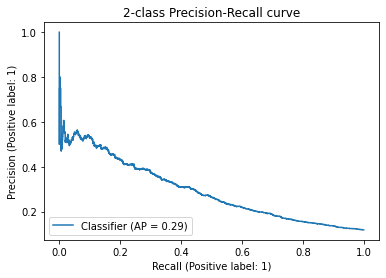

In [146]:
# y_score = classifier.decision_function(X_test)
display = PrecisionRecallDisplay.from_predictions(y_test, prediction)
_ = display.ax_.set_title("2-class Precision-Recall curve")

# Model Fit - 5. Single Layer NN
---
* Fitting a single layer model
* Model evaluation and results
* Next steps for greater accuracy

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2022-08-08 17:00:33.943594: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [31]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_shape=(X_train_scaled.shape[1],), activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_scaled, y_train, epochs=5, batch_size=10)


Epoch 1/5
2552/2552 [==============================] - 8s 3ms/step - loss: 0.4480 - accuracy: 0.8267
Epoch 2/5
2552/2552 [==============================] - 7s 3ms/step - loss: 0.3636 - accuracy: 0.8822
Epoch 3/5
2552/2552 [==============================] - 7s 3ms/step - loss: 0.3596 - accuracy: 0.8824
Epoch 4/5
2552/2552 [==============================] - 8s 3ms/step - loss: 0.3581 - accuracy: 0.8825
Epoch 5/5
2552/2552 [==============================] - 7s 3ms/step - loss: 0.3562 - accuracy: 0.8825


In [32]:
# evaluate the keras model
_, accuracy = model.evaluate(X_test_scaled, y_test)
accuracy

342/342 [==============================] - 1s 2ms/step - loss: 0.3594 - accuracy: 0.8824


0.8824282288551331

In [56]:
preds = model.predict(X_test_scaled)

In [57]:
preds[preds>=0.11] = 1
preds[preds<0.11] = 0
y_pred = preds

In [156]:
confusion_matrix(y_test, y_pred)

array([[3840, 5811],
       [ 397,  890]])

In [58]:
# close to 52% recall
recall_score(y_test, y_pred)

0.5221445221445221

# Model Fit - 6. Simple Decision Tree without parameter tuning
---
* Fitting a single decision tree
* Model evaluation and results
* Limitations of Decision Tree

In [61]:
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_scaled, y_train)
y_pred = DT_model.predict(X_test_scaled)

In [62]:
confusion_matrix(y_test, y_pred)

array([[9002,  649],
       [ 990,  297]])

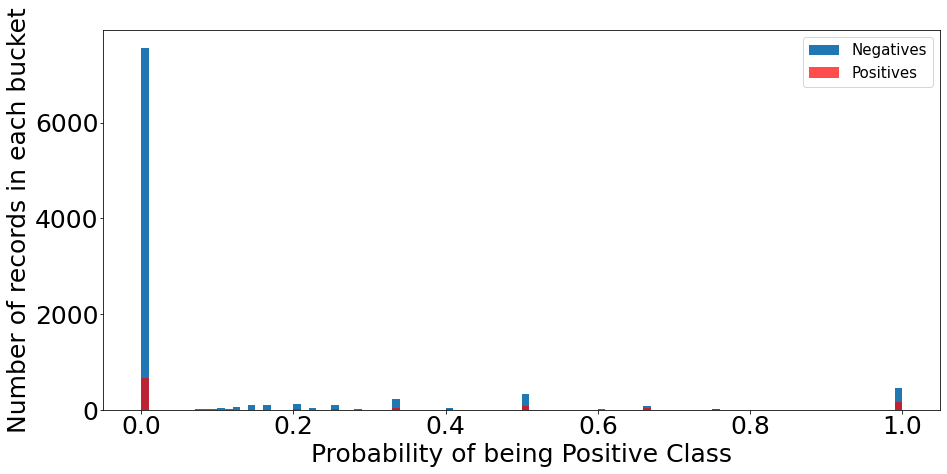

In [63]:
predicted_probs = DT_model.predict_proba(X_test_scaled)
prediction = predicted_probs[:,1]

plt.figure(figsize=(15,7))
plt.hist(prediction[y_test['label'] == 0], bins=100, label='Negatives')
plt.hist(prediction[y_test['label'] == 1], bins=100, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.ylabel('Number of records in each bucket', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=1)
plt.show() 

In [64]:
prediction[prediction>=0.01] = 1
prediction[prediction<0.01] = 0

In [65]:
confusion_matrix(y_test, prediction)

array([[7557, 2094],
       [ 682,  605]])

In [66]:
precision_score(y_test, prediction)

0.22415709522045202

In [67]:
recall_score(y_test, prediction)

0.4700854700854701

In [68]:
accuracy_score(y_test, prediction)

0.7462058877308466

# Conclusion
---

* Optimizing for recall costs precision, better model should give better results
* XGB with bayesian optimization gives the best result, but there is scope for improvement
    * Access to more compute power can increase the accuracy
* NN with bayesian optimization can output better accuracy, since with a single layer model we achieve ~50% - ~60% recall, but requires massive compute power
* Feature engineering can be improved for better accuracy